#### **Fake News Detector**

##### Group Members:



1.   Nimrah Jawed (nj04707)
2.   Umme Salma (us04315)
3.   Qazi Talha (qt05099)




#### **Data Reading and Parsing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score
import sklearn
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from numpy.random import rand
from numpy import log, dot, e
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import functools
from sklearn.metrics import accuracy_score
import operator 
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier 
import pickle
from io import StringIO 
import ast
from numpy import asarray
from numpy import save
from numpy import load
import json


#### **Data Set**

The Data is extracted from: https://www.kaggle.com/clmentbisaillon/fake-and-real-news-dataset




In [ ]:
fake_data = pd.read_csv('/content/drive/MyDrive/Data/Fake.csv')
true_data = pd.read_csv('/content/drive/MyDrive/Data/True.csv')
print(fake_data.shape)
print(true_data.shape)

(23481, 4)
(21417, 4)


In [ ]:
true_data['label'] = 1
fake_data['label'] = 0

In [ ]:
data_frame = pd.concat([true_data, fake_data], ignore_index=True)

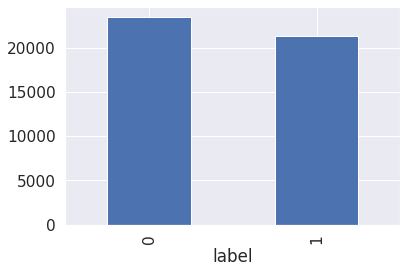

In [ ]:
data_frame.groupby("label")['text'].count().plot.bar()


#### **Data Cleaning and formatting**

In [ ]:
data_frame.drop(data_frame[data_frame.text == " "].index.tolist(), inplace=True)

In [ ]:
data_frame.drop(data_frame[data_frame.duplicated()].index.tolist(), inplace=True)
data_frame
#We have 405 samples that match with each other in terms of title, text, date and subject, so we remove them.

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1
...,...,...,...,...,...
44893,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016",0
44894,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016",0
44895,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016",0
44896,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016",0


In [ ]:
data_frame.drop(['title','subject','date'], axis=1, inplace=True)
data_frame

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
44893,21st Century Wire says As 21WIRE reported earl...,0
44894,21st Century Wire says It s a familiar theme. ...,0
44895,Patrick Henningsen 21st Century WireRemember ...,0
44896,21st Century Wire says Al Jazeera America will...,0


In [ ]:
data_frame.drop(data_frame[data_frame.duplicated(['text'])].index.tolist(),inplace=True)
data_frame

#duplicated text remove

,text,label
0,WASHINGTON (Reuters) - The head of a conservat...,1
1,WASHINGTON (Reuters) - Transgender people will...,1
2,WASHINGTON (Reuters) - The special counsel inv...,1
3,WASHINGTON (Reuters) - Trump campaign adviser ...,1
4,SEATTLE/WASHINGTON (Reuters) - President Donal...,1
...,...,...
44115,21st Century Wire says All the world s a stage...,0
44116,Randy Johnson 21st Century WireThe majority ...,0
44117,Tune in to the Alternate Current Radio Network...,0
44118,21st Century Wire says A new front has just op...,0


In [ ]:
accuracy_dict={}
accuracy_dict["dts"]=0
accuracy_dict["nb"]=0
accuracy_dict["nbs"]=0
accuracy_dict["lro"]=0
accuracy_dict["lrs"]=0

In [ ]:
nltk.download('stopwords')
nltk_stopwords = stopwords.words('english')
wordcloud_stopwords = STOPWORDS

nltk_stopwords.extend(wordcloud_stopwords)

stopwords = set(nltk_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Now we clean the title feature

We remove urls (if any)
Perform decontractions
Non-acronize few popular words
Remove punctuations and all special characters
Remove stopwords

In [ ]:
def clean(text):
    text = text.lower()
    #remove URLS
    text = re.sub("http\S+", '', str(text))

    # Punctuations & special characters
    text = re.sub("[^A-Za-z0-9]+"," ", str(text))
    text = re.sub(r"'s$", " is", str(text))
    text = re.sub(r"'re$", " are", str(text))
    text = re.sub(r"'t$", " not", str(text))
    text = re.sub(r"'ll$", " will", str(text))
    text = re.sub(r"'ve$", " have", str(text))
    text = re.sub(r"'d$", " would", str(text))
    text = re.sub('\n', '', text)
   
    # Stop word removal
    text = " ".join(str(i).lower() for i in text.split() if i.lower() not in stopwords)

    return text

In [ ]:
data_frame['text']=data_frame['text'].apply(clean)

#### **Spliting into train test and using Tf-Idf**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data_frame.drop('label',axis=1), data_frame.label, test_size=0.2, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(30916, 1) (30916,)
(7729, 1) (7729,)


In [ ]:
vectorizer = TfidfVectorizer(min_df=0.01,ngram_range=(1,3))
vectorizer.fit(X_train.text)

X_tr = vectorizer.transform(X_train.text)
X_te = vectorizer.transform(X_test.text)

print(X_tr.shape, X_te.shape)

(30916, 3513) (7729, 3513)


### **Models**

#### **Logistic Regression (Our Model)**

In [ ]:
def sigmoid(value):
    ans = 1/(1 + np.exp(-value))
    return (ans)


def train(X, y, lr, iters):
    no_of_samples, no_of_features = X.shape

    weights = np.zeros(no_of_features)
    bias = 0

    for i in range(iters):
        
        # train model to get predictions
        model = X.dot(weights) 
        y_pred = sigmoid(model)

        #Analyze cost decrese
        cost = -(1/no_of_samples) * np.sum(y*np.log(model))
        
        #Check minima from gradient
        gradient = 1/no_of_samples  * X.T.dot(y_pred - y)

        #update weights
        weights -= lr * gradient

    return weights


def predict(X, weights):
    #Predicting on input
    model = X.dot(weights) 
    y_pred = sigmoid(model)
    list_of_predicted_labels = [1 if i > 0.5 else 0 for i in y_pred]
    return np.array(list_of_predicted_labels)

#Set Values
lr = 0.001
iters = 1000

weights = train(X_tr, y_train, lr, iters)

# save('weights.npy', weights)




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

divide by zero encountered in log

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: RuntimeWarning:

invalid value encountered in log



In [ ]:
y_pred = predict(X_te, weights)
accuracy  = np.sum([y_pred==y_test])/ len(y_test)
print(accuracy)
accuracy_dict["lro"]=accuracy

0.882520377797904


#### **Logistic Regression- SCIKIT Learn Model**

In [ ]:
logreg = LogisticRegression()
learnmodel = logreg.fit(X_tr, y_train)
lr_prediction = learnmodel.predict(X_te)
accuracy = accuracy_score(lr_prediction, y_test)
print("The accuracy score is :",accuracy)
accuracy_dict["lrs"]=accuracy

The accuracy score is : 0.987449864148014


#### **Naive Bayes (Our Model)**

In [ ]:
class_prob_dict={}

def learn_model(data,target):
    
    #get list of all classes
    class_list = sorted(target.unique())
    encoded_doc = data.toarray()

    #find shape of the data
    get_index = lambda data, i : data[i]
    data_row = get_index(encoded_doc.shape, 0)
    data_col = get_index(encoded_doc.shape,1)

    #creating a 2d array of conditional probabilities
    conditioned_probabilities =np.array([[0.0 for j in range(data_col)] for i in range(len(class_list))])
    
    #initializing probabilites with 0
    for i in range(len(class_list)):
      class_prob_dict[class_list[i]]=0
    
    #populating class dictionary with its probabilities
    for i in range(len(class_list)):
      current= encoded_doc[target == class_list[i]]
      class_row= get_index(current.shape, 0)
      class_prob_dict[class_list[i]]= float(class_row/data_row)
      #populating the 2d array by finding conditional probabilities
      #laplace smoothing
      conditioned_probabilities [i]=(np.sum(current,axis=0) +1)
      conditioned_probabilities [i]=conditioned_probabilities [i]/np.sum(conditioned_probabilities [i])
      
    classifier= conditioned_probabilities
    return classifier




def classify(classifier, testdata):
  
    predicted_val=[]
    #finding number of rows in testdata
    Test = testdata.toarray()
    get_index = lambda data, i : data[i]
    test_row =  get_index(Test.shape, 0)
    
    #initializing 
    conditioned_probabilities = classifier
    class_prob = class_prob_dict.copy()
    classes = list(class_prob.keys())
    class_list_len = len(classes)



    for i in range(test_row):
      #initial probabilities of all classes is -1
      most_likely_class_list = [-1 for i in range(class_list_len)]
      for j in range(class_list_len):
        #finding probability of a particular class
        prob_class = class_prob[classes[j]]
        #finding all probabilites of Attribute given class
        prob_attr_given_class_list =  conditioned_probabilities[j][Test[i]!=0]
        #multiplying all probabilities of Attribute given class
        prob_attr_given_class =functools.reduce(operator.mul, prob_attr_given_class_list,1)
        #computing P(A|C)*P(C)
        most_likely_class_list[j]= float(prob_attr_given_class)*prob_class

      #selecting class with max probability
      most_likely_class =np.argmax(most_likely_class_list)
      predicted_val.append(classes[most_likely_class])

    return predicted_val


def evaluate(actual_class, predicted_class):   

    #finding accuracy     
    accuracy = -1  
    accuracy  = np.sum([actual_class==predicted_class])/ len(actual_class) 
    actual_class = list(actual_class)

    #confusion Matrix
    cf = confusion_matrix(actual_class, predicted_class)

    #calculating TP, FP, FN and TN
    TP=[]
    for i in range(len(cf)):
      for j in range(len(cf)):
        if (i==j):
          TP.append(cf[i][j])
    
    FP =[]
    FN = []
    for i in range (len(cf)):
      calcFP= 0
      calcFN=0
      for j in range(len(cf)):
        
        calcFP+=cf[i][j]
        calcFN+=cf[j][i]
      FP.append(calcFP)
      FN.append(calcFN)

    #precision
    #TP/TP+FP
    Precision=[]

    #f_measure
    #2*Precision*Recall/Precision+Recall
    Fmeasure = []

    #Recall
    #TP/TP+FN
    Recall=[]

    for i in range(len(TP)):
      if TP[i]==0:
        Precision.append(0)
        Recall.append(0)
        Fmeasure.append(0)
      else:
        calcP= TP[i]/FP[i]
        Precision.append(calcP)
        calcR = TP[i]/FN[i]
        Recall.append(calcR)
        calcFm = (2*calcP*calcR)/(calcP+calcR)
        Fmeasure.append(calcFm)
    
    print("The accuracy score is :",accuracy)
    accuracy_dict["nb"]=accuracy
    print("The accuracy in % is: ",round(accuracy*100,2),"%")
    print("The Precision is :",Precision)
    print("The Recall is :",Recall)
    print("The F_measure is :",Fmeasure)


print("Learning model.....")
model = learn_model(X_tr, y_train)

# save('NB.npy', model)
# data = load('NB.npy')
# y_pred = classify(model, X_te)
# f = open("dictionary.pkl","wb")
# pickle.dump(class_prob_dict,f)
# f.close()
# x=load("dictionary.pkl", "rb", allow_pickle=True)
# print(x)
print("Classifying test data......")  
predictedY = classify(model, X_te)
# print(predictedY)

print("Evaluating results.....")
evaluate(y_test,predictedY)



Learning model.....
Classifying test data......
Evaluating results.....
The accuracy score is : 0.6473023677060422
The accuracy in % is:  64.73 %
The Precision is : [0.9798966111430213, 0.3746173769719802]
The Recall is : [0.5622940013183916, 0.9578567128236002]
The F_measure is : [0.7145549738219896, 0.5385917400135409]


#### **Naive Bayes- SCIKIT Learn Model**

In [ ]:
MNB = MultinomialNB()
learnmodel = MNB.fit(X_tr, y_train)
MNB_prediction = learnmodel.predict(X_te)
accuracy = accuracy_score(MNB_prediction, y_test)  
print("The accuracy score is :",accuracy)
accuracy_dict["nbs"]=accuracy
# filename = 'MNB_model.sav'
# pickle.dump(MNB, open(filename, 'wb'))

The accuracy score is : 0.9455298227455039


#### **Decision Tree- SCIKIT Learn Model**

In [ ]:
DT=DecisionTreeClassifier()
LM=DT.fit(X_tr, y_train)
dtpred=LM.predict(X_te)
accuracy =accuracy_score(dtpred, y_test)
print("The accuracy score is :",accuracy)
accuracy_dict["dts"]=accuracy
# filename = 'DT_model.sav'
# pickle.dump(DT, open(filename, 'wb'))

The accuracy score is : 0.9948246862466037


#### **Performance Measures**

In [ ]:
def evaluate(actual_class, predicted_class):
        
    accuracy = accuracy_score(predicted_class, actual_class)  
    precision = precision_score(predicted_class, actual_class, average=None)
    recall = recall_score(predicted_class, actual_class, average=None)
    f_measure = f1_score(predicted_class, actual_class,average=None) 
    
    
    print("The accuracy score is :",accuracy)
    print("The accuracy in % is: ",round(accuracy*100,2),"%")
    print("The precision score is :",precision)
    print("The recall score is :",recall)
    print("The f_measure score is :",f_measure,"\n")

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


Model: Decision tree Classifier
The accuracy score is : 0.9948246862466037
The accuracy in % is:  99.48 %
The precision score is : [0.99396898 0.99552625]
The recall score is : [0.99454023 0.99505766]
The f_measure score is : [0.99425452 0.9952919 ] 



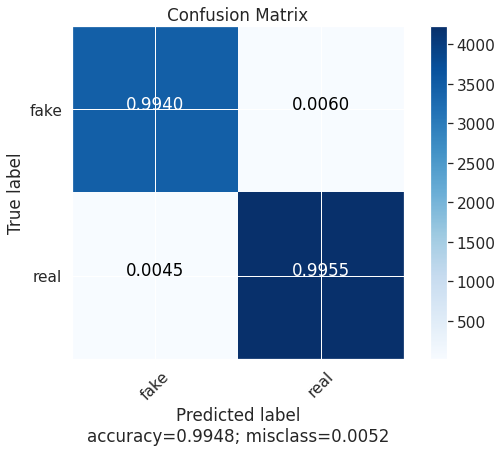

In [ ]:
# Decision Tree
print( "Model: Decision tree Classifier")
evaluate(y_test, dtpred)
cdt= confusion_matrix(y_test, dtpred)
plot_confusion_matrix(cm           = cdt, 
                      normalize    = True,
                      target_names = ['fake', 'real'],
                      title        = "Confusion Matrix")


Model:Multinomial Naive Bayes using Sk-learn
The accuracy score is : 0.9455298227455039
The accuracy in % is:  94.55 %
The precision score is : [0.92935095 0.95879444]
The recall score is : [0.9486954  0.94302918]
The f_measure score is : [0.93892355 0.95084647] 



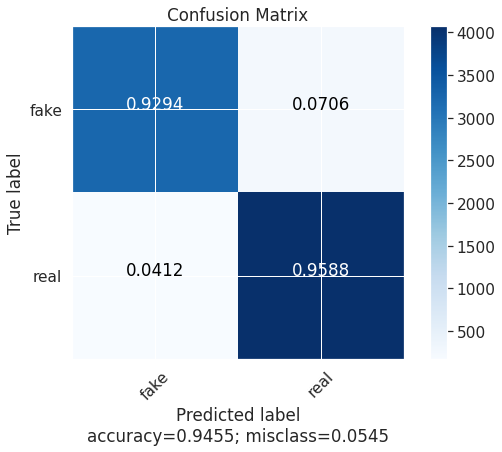

In [ ]:
# Multinomial Naive Bayes Sklearn
print("Model:Multinomial Naive Bayes using Sk-learn")
evaluate(y_test, MNB_prediction)
Mnb=confusion_matrix(y_test, MNB_prediction)
plot_confusion_matrix(cm           = Mnb, 
                      normalize    = True,
                      target_names = ['fake', 'real'],
                      title        = "Confusion Matrix")


Model: Naive bayes - own implementation
The accuracy score is : 0.6473023677060422
The accuracy in % is:  64.73 %
The precision score is : [0.97989661 0.37461738]
The recall score is : [0.562294   0.95785671]
The f_measure score is : [0.71455497 0.53859174] 



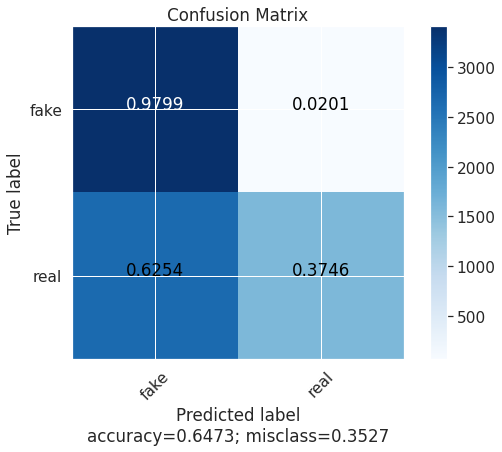

In [ ]:
# Naive Bayes Own implementation
print("Model: Naive bayes - own implementation")
NBo=confusion_matrix(y_test, predictedY)
evaluate(y_test, predictedY)
plot_confusion_matrix(cm           = NBo, 
                      normalize    = True,
                      target_names = ['fake', 'real'],
                      title        = "Confusion Matrix")

Model: Logistic regression using Scikit learn
The accuracy score is : 0.987449864148014
The accuracy in % is:  98.74 %
The precision score is : [0.97960942 0.99387803]
The recall score is : [0.99243526 0.9834576 ]
The f_measure score is : [0.98598063 0.98864036] 



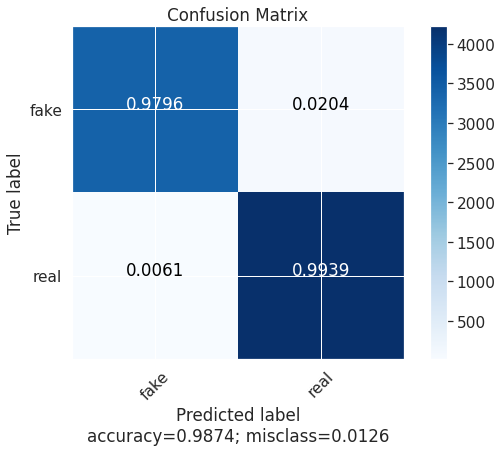

In [ ]:
# Logistic regression using Sklearm
print( "Model: Logistic regression using Scikit learn")
evaluate(y_test, lr_prediction)
LRs=confusion_matrix(y_test, lr_prediction)
plot_confusion_matrix(cm           = LRs, 
                      normalize    = True,
                      target_names = ['fake', 'real'],
                      title        = "Confusion Matrix")

Model: Logistic regression - own implementation
The accuracy score is : 0.882520377797904
The accuracy in % is:  88.25 %
The precision score is : [0.74870764 0.99222981]
The recall score is : [0.9875     0.82806052]
The f_measure score is : [0.85168246 0.90274207] 



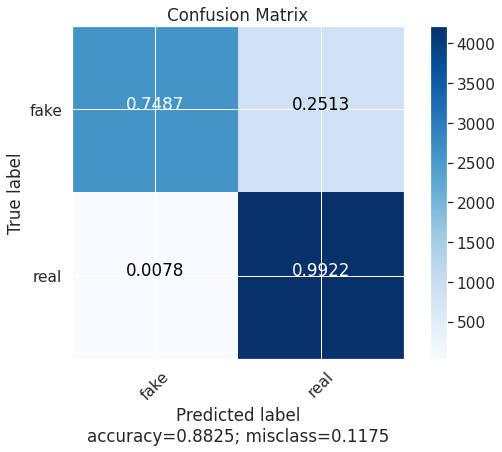

In [ ]:
# Logistic regression using own
print("Model: Logistic regression - own implementation")
LRo=confusion_matrix(y_test, y_pred)
evaluate(y_test, y_pred)
plot_confusion_matrix(cm           = LRo, 
                      normalize    = True,
                      target_names = ['fake', 'real'],
                      title        = "Confusion Matrix")